In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.image as mpimg
import glob
import time

import scipy.misc
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
from skimage.feature import hog

In [2]:
def plot3d(pixels, colors_rgb,
        axis_labels=list("RGB"), axis_limits=[(0, 255), (0, 255), (0, 255)]):
    """Plot pixels in 3D."""

    # Create figure and 3D axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation

In [3]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

In [4]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [5]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient=9, pix_per_cell=8, cell_per_block=2,
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [78]:
def extract_features_img(img,cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256), orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,debug=0):
# apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else: 
            image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # convert to rgb
            feature_image = np.copy(image)
    
        t1 = time.time()
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        
        t2 = time.time()
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        
        t3 = time.time()
        # Call get_hog_features() with vis=False, feature_vec=True
        hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        t4 = time.time()
        
        if debug:   
            print ('spatial_time = ',(t2-t1)*1000,' ms')
            print ('histogram_time = ',(t3-t2)*1000,' ms')
            print ('hog_time = ',(t4-t3)*1000,' ms')
            hog_features_0, hog_img_0= get_hog_features(feature_image[:,:,0], orient, 
                                        pix_per_cell, cell_per_block, vis=True, feature_vec=True)
            hog_features_1, hog_img_1= get_hog_features(feature_image[:,:,1], orient, 
                                        pix_per_cell, cell_per_block, vis=True, feature_vec=True)
            hog_features_2, hog_img_2= get_hog_features(feature_image[:,:,2], orient, 
                                        pix_per_cell, cell_per_block, vis=True, feature_vec=True)
#             cv2.imwrite('RGB_hog_0.png',hog_img_0)
#             cv2.imwrite('RGB_hog_1.png',hog_img_1)
#             cv2.imwrite('RGB_hog_2.png',hog_img_2)
            
            width = 1/1.5
            fig, ax = plt.subplots( nrows=1, ncols=1 )  # create figure & 1 axis
            fig.tight_layout();
            ax.bar(range(len(spatial_features)), spatial_features, width, color="blue")
            filename = cspace+'_spatial_features'
            fig.suptitle(filename, fontsize=12)
            plt.show()
            fig.savefig('output_images/'+filename+'.png')
            ###########################################################################
            fig, ax = plt.subplots( nrows=1, ncols=1 )  # create figure & 1 axis
            fig.tight_layout();
            ax.bar(range(len(hist_features)), hist_features, width, color="blue")
            filename = cspace+'_hist_features'
            fig.suptitle(filename, fontsize=12)
            plt.show()
            fig.savefig('output_images/'+filename+'.png')
            ###########################################################################
            fig, ax = plt.subplots( nrows=1, ncols=1 )  # create figure & 1 axis
            fig.tight_layout();
            ax.bar(range(len(hog_features)), hog_features, width, color="blue")
            filename = cspace+'_hog_features'
            fig.suptitle(filename, fontsize=12)
            plt.show()
            fig.savefig('output_images/'+filename+'.png')
            ###########################################################################
            fig, ax = plt.subplots( nrows=1, ncols=1 )  # create figure & 1 axis
            fig.tight_layout();
            ax.axis('off')
            plt.imshow(hog_img_0,cmap='gray')
            filename = cspace+'_hog_ch_0'
            fig.suptitle(filename, fontsize=12)
            plt.show()
            fig.savefig('output_images/'+filename+'.png')
            ###########################################################################
            fig, ax = plt.subplots( nrows=1, ncols=1 )  # create figure & 1 axis
            fig.tight_layout();
            ax.axis('off')
            plt.imshow(hog_img_1,cmap='gray')
            filename = cspace+'_hog_ch_1'
            fig.suptitle(filename, fontsize=12)
            plt.show()
            fig.savefig('output_images/'+filename+'.png')
            ###########################################################################
            fig, ax = plt.subplots( nrows=1, ncols=1 )  # create figure & 1 axis
            fig.tight_layout();
            ax.axis('off')
            plt.imshow(hog_img_2,cmap='gray')
            filename = cspace+'_hog_ch_2'
            fig.suptitle(filename, fontsize=12)
            plt.show()
            fig.savefig('output_images/'+filename+'.png')

        return np.concatenate((spatial_features, hist_features, hog_features))

In [79]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
# this function combines color, histogram and hog features extraction
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256), orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,debug=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
#         image = mpimg.imread(file)
        image = cv2.imread(file) # reads a file into bgr values 0-255
        img_features = extract_features_img(img,cspace='RGB',hog_channel=0,debug=debug)
        # Append the new feature vector to the features list
        features.append(img_features)
        
    # Return list of feature vectors
    return features

In [80]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5),max_y=780):
    height, width, channels = img.shape
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = int(xs*nx_pix_per_step + x_start_stop[0])
            endx = int(startx + xy_window[0])
            starty = int(ys*ny_pix_per_step + y_start_stop[0])
            endy = int(starty + xy_window[1])
            # Append window position to list
            if endy<height and endx < width and endy<max_y:
                window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

spatial_time =  0.013589859008789062  ms
histogram_time =  0.5838871002197266  ms
hog_time =  1.2407302856445312  ms


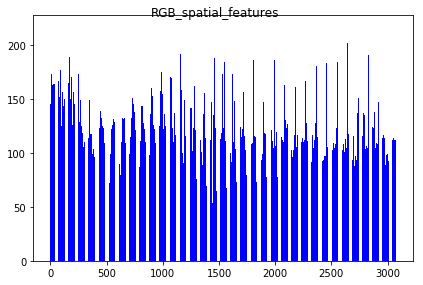

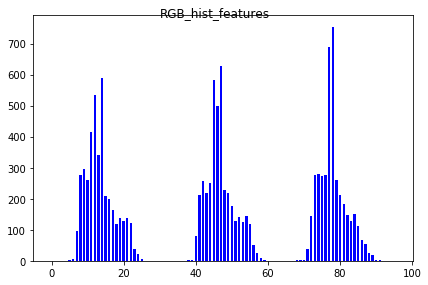

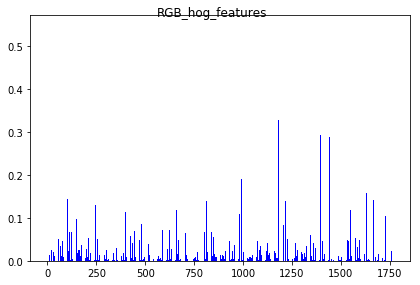

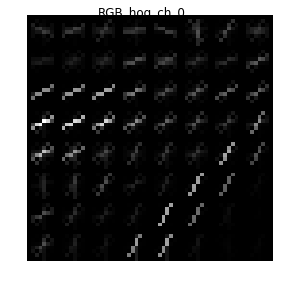

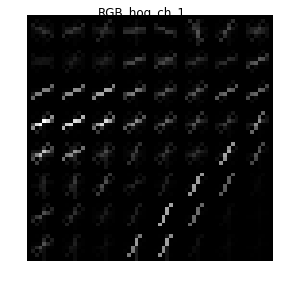

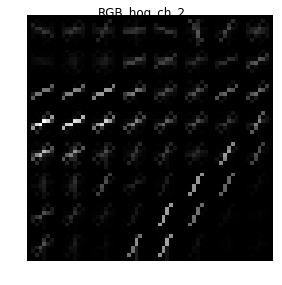

array([  1.46000000e+02,   1.56000000e+02,   1.37000000e+02, ...,
         1.53337504e-02,   1.80869185e-02,   6.85306287e-03])

In [81]:
# Check the profile time for a single sample
# t=time.time()        
file='test_images/not_car.png'
# file='test_images/car.png'
# image = cv2.imread(file)
image = scipy.misc.imread(file)
size = (64,64)
img = cv2.resize(image, size)#.astype(np.float32)
extract_features_img(img,cspace='RGB',debug=1)
# extract_features_img(img,cspace='HSV',debug=1)
# extract_features_img(img,cspace='LUV',debug=1)
# extract_features_img(img,cspace='HLS',debug=1)
# extract_features_img(img,cspace='YUV',debug=1)
# extract_features_img(img,cspace='YCrCb',debug=1)
# t2 = time.time()
# print(round(t2-t,1), 'Seconds')